# GradCam for all Models in a Fold

Investigate GradCam:
- Compare one model with all models per Fold
- Study the heatmap uncertainty
- Plot multiple layers
- Compare last convolutional layer with the mean over all convolutional layer
- (For paper model only: Compare the heatmap of patients in different folds)
- Examine impurity in the original image and the impact on the heatmap
- Loop through the slices 

## Load Libraries and Modules

In [55]:
#!pip install scikit-image
#!pip install skimage

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import skimage
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [42]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import functions_metrics as fm
import functions_read_data as rdat
import functions_model_definition as md
import functions_gradcam as gc
import functions_plot_heatmap as phm

/tf/notebooks/schnemau/xAI_stroke_3d


## Load Data and Define Parameters

In [3]:
# Define the path + output path:
DATA_DIR = DIR + "data/"

version = "10Fold_sigmoid_V3" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False # whether to save the plot

# Define Model Version
model_version = 1

# define paths
WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    DIR, version, model_version, 
    hm_type = "gc", ending = "")

In [4]:
## load images and ids
(X_in, pat, id_tab, all_results, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)

In [5]:
# 10 choosen patients which are in andreas split 6
split_6_pats = [297, 299, 319, 460, 483, 529, 27, 35, 125, 481]

## Model

In [6]:
# define model
(input_dim, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True

In [7]:
input_dim

(128, 128, 28, 1)

In [8]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR) 

# Plot GradCams

## Compare one Model to all Models

Select a patient and compare the heatmap of one model to the ensemble of all models.

In [9]:
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
237,1,1,1.0,0,train,train,train,val,train,train,...,0.225657,0.238935,0.238855,0.233893,0.233858,0.240781,0,0.005467,0.012478,True
120,2,2,1.0,0,train,train,train,train,test,train,...,0.047887,0.161724,0.080574,0.116755,0.107362,0.240781,0,0.049707,0.216806,True
238,3,3,0.0,0,train,train,train,val,train,train,...,0.215078,0.230941,0.228632,0.226448,0.226394,0.240781,0,0.006469,0.017104,True
239,4,5,0.0,0,train,train,train,val,train,train,...,0.221537,0.234562,0.234974,0.231038,0.230998,0.240781,0,0.005668,0.013406,True
0,5,6,3.0,1,test,train,train,train,train,val,...,0.316242,0.210725,0.228032,0.228860,0.224606,0.240781,0,0.058630,0.258022,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,392,539,1.0,0,train,test,train,train,train,train,...,0.235187,0.315802,0.279838,0.296943,0.295011,0.240781,1,0.050413,0.220068,False
89,393,540,2.0,0,train,train,test,train,train,train,...,0.242043,0.356276,0.376062,0.335027,0.332953,0.240781,1,0.053183,0.232860,False
29,394,541,0.0,0,test,train,train,train,train,val,...,0.194216,0.107949,0.126793,0.158930,0.151696,0.240781,0,0.062534,0.276052,True
149,395,542,1.0,0,train,train,train,train,test,train,...,0.180415,0.309532,0.364905,0.329155,0.320663,0.240781,1,0.112732,0.507900,False


In [10]:
# select patient
p_ids = [42]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in, 
                                                                 gen_model_name = generate_model_name,
                                                                 num_models = num_models)
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,93,32,42,2.0,0,train,train,train,test,train,...,0.284154,0.350431,0.307981,0.301949,0.301299,0.240781,1,0.030253,0.126957,False


In [13]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]
vis_layers

['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']

In [14]:
layers_to_apply_gradcam = ["conv3d_1", "conv3d_2", "conv3d_3"]
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][1]],
    layers = layers_to_apply_gradcam,
    #layers = vis_layers,
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "last")

In [46]:
np.squeeze(resized_img, axis=-1)

array([[[-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        ...,
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042]],

       [[-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        ...,
        [-0.6206042, -0.6206042, -0.6206042, ..., -0.6206042,
         -0.6206042, -0.6206042],
        [-0.

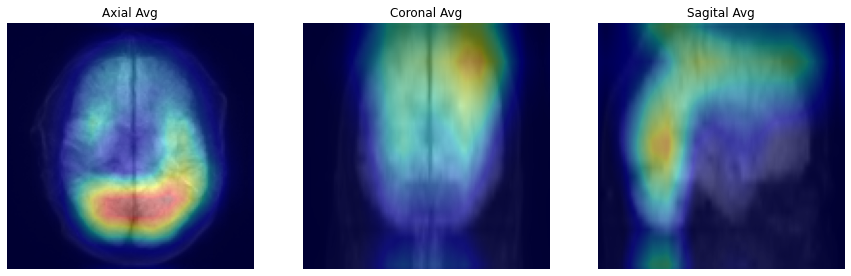

In [47]:
# only one model
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][1]],
    layers = "conv3d_3",
    #layers = vis_layers,
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "last")

phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
            version = "overlay",
            mode = "avg")


#phm.plot_heatmap(resized_img, heatmap,
#            version = "overlay",
#            mode = "max")
#phm.plot_heatmap(resized_img, heatmap,
#            version = "original",
#            mode = "max")

In [37]:
resized_img.shape

(128, 128, 28, 1)

TypeError: Invalid shape (128, 128, 1) for image data

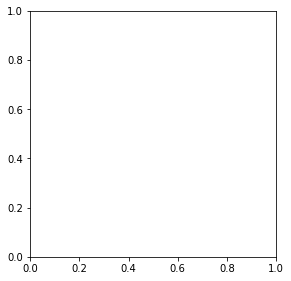

In [21]:
# all models
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers[3],
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "last",
    gcpp_hm = "last")

#phm.plot_heatmap(resized_img, heatmap,
#            version = "overlay",
#            mode = "avg")

#phm.plot_heatmap(resized_img, heatmap,
#            version = "overlay",
#            mode = "max")

#phm.plot_heatmap(resized_img, heatmap,
#            version = "original",
#            mode = "max",
#            orig_max=True)

#phm.plot_heatmap(resized_img, heatmap,
#             version = "original",
#             mode = "def",
#             slices=(78,95,6))


Plot the positve and negative heatmap.

In [ ]:

# all models
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers[3],
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "none",
    gcpp_hm="none")

phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "avg", 
            hm_colormap="bwr", hm_positive=False)
phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "max", 
            hm_colormap="bwr", hm_positive=False)
phm.plot_heatmap(resized_img, heatmap,
            version = "original",
            mode = "max")

In [ ]:
print(heatmap.min(), heatmap.max())

## Model Uncertainty Heatmap

Plot the heatmap uncertainty for the ensemble.

In [ ]:
# print highest activation slice for each model
heatmaps = []
for i in range(5):
    heatmap0, resized_img, max_hm_slice0, hm_mean_std0 = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][i]],
    layers = "conv3d_3",
    model_mode = "mean")
    print(np.unravel_index(np.argmax(heatmap0), heatmap0.shape))
    heatmaps.append(heatmap0)
heatmaps = np.array(heatmaps)
heatmaps.shape
heatmap_var = np.var(heatmaps, axis = 0)
print(np.sqrt(np.mean(heatmap_var)))

In [ ]:
# plot the uncertainty (standard deviation of each voxel) of the heatmap
phm.plot_heatmap(resized_img, heatmap_var,
            version = "overlay",
            mode = "avg")
phm.plot_heatmap(resized_img, heatmap_var,
            version = "overlay",
            mode = "max")
# phm.plot_heatmap(resized_img, heatmap,
#             version = "original",
#             mode = "max")

In [ ]:
# print the heatmap mse (mean squared error) and ssim (structural similarity index) between all models
# this indicates the similarity between two heatmaps (small mse and high ssim = similar heatmaps)
from skimage.metrics import structural_similarity, mean_squared_error, normalized_root_mse

mse = []
ssim = []

for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
        mse.append(mean_squared_error(heatmaps[i].squeeze(), heatmaps[j].squeeze()))
        ssim.append(structural_similarity(heatmaps[i].squeeze(), heatmaps[j].squeeze(), data_range=1, multichannel = False))
        
print(np.array(mse).reshape((5,5)))
print(np.array(ssim).reshape((5,5)))

## Plot multiple Layers

Loop over the given layers and plot the GradCAMs for each layer.
Additionally, plot the average over all layers and the original image.  
For each layer the average over one axis and the highest activation slice is plotted.  

In early layers GradCam++ often highlights the background, while in later layers it highlights the object.  
Therefore, the average over all layers should be calculated by using the absolute activation values for all except the last convolutional layer. However, this can be changed by setting `gcpp_hm = "all" or "none"`. It is then recommended to adjust the gradcam plot function accordingly (`hm_colormap="bwr", hm_positive=False`).

In [ ]:
# select patient
p_ids = [42]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

In [ ]:
model_mode = "mean"
layer_mode = "mean"
invert_hm = "last" if res_table.y_pred_class[0] == 1 else "none"
gcpp_hm = "last"

res_table.y_pred_class

# vis_layers = [i.name for i in model_3d.layers[1:-6]] # all layers
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")] # only conv layers

if "sigmoid" in str(model_3d.layers[-1].activation):
        pred_idx = 0
elif "softmax" in str(model_3d.layers[-1].activation):
        pred_idx = 1
        
model_nrs = list(range(num_models)) # all models per fold
# model_nrs = [0] # define which models

for j in range(len(res_table)):   
    plot_per_iter = 2
    plot_at_end = 1
    num_rows = len(vis_layers)*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.12
    end_text = 0.88
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.6/(num_rows-plot_at_end), 
        end_text-0.6/(num_rows-plot_at_end), 
        len(vis_layers)+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+5/num_rows/15, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+4/num_rows/15, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+3/num_rows/15, "true class: " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/15, "pred prob (class 1):  " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/15, "pred class:  " + str(res_table["y_pred_class"][j]), fontsize=16)

    for i, vis_layer in enumerate(vis_layers):
#         print("Layer: ", vis_layer)
        plt.gcf().text(0.1, text_pos[i], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
        heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layer,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm,
            gcpp_hm = gcpp_hm)
        
        phm.plot_heatmap(resized_img, heatmap,
                     version = "overlay",
                     mode = "avg",
                     add_plot = (i*2,num_rows),
                     show = False)
        phm.plot_heatmap(resized_img, heatmap,
                     version = "overlay",
                     mode = "max",
                     add_plot = (i*2+1,num_rows),
                     show = False)
        
    # average over all layers
    heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm,
            gcpp_hm = gcpp_hm)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + "over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    phm.plot_heatmap(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (num_rows-3,num_rows),
                show = False)
    phm.plot_heatmap(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (num_rows-2,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    phm.plot_heatmap(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    if save_plot:
        plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_' + pic_save_name + '_all_conv_layers.png')


## Plot last conv and average of conv layer

First, plot the mean over all axis for the last conv layer and the average layer. 
Second, plot the highest activation slice for the last conv layer and the average layer.

This is the same style as PowerPoint (230123_Resultate_10Fold_bs4.pptx, 230123_Resultate_andrea_split6.pptx).

In [ ]:
all_results

In [ ]:
# select patient
p_ids = [42]
# p_ids = split_6_pats

if version == "andrea":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # andrea split
elif version.startswith("10Fold"):
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # 10 Fold

if save_plot:
    res_table[["p_id", "mrs", "unfavorable", "test_split", "y_pred_model_10", 
               "y_pred_model_11", "y_pred_model_12", "y_pred_model_13", "y_pred_model_14", 
               "y_pred_trafo_avg", "threshold", "y_pred_class", "y_pred_unc"]].to_csv(
        DATA_OUTPUT_DIR + "andrea_split6_meta_data.csv",  index=False)

In [ ]:
# vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

In [ ]:
res_table

In [ ]:
phm.plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    model_3d = model_3d,
    layer_mode = "mean", 
    heatmap_mode = "avg", 
    save_path = PIC_OUTPUT_DIR, 
    save_name = pic_save_name, save = save_plot)

In [ ]:
phm.plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    model_3d = model_3d,
    layer_mode = "mean", 
    heatmap_mode = "max", 
    save_path = PIC_OUTPUT_DIR, 
    save_name = pic_save_name, save = save_plot)

## Analysis of Patients in multiple splits

The heatmaps of one ensemble member to another normally do not differ to much from each other. However, if a different fold was used for training, the heatmaps can differ morge significantly.  
This comparison only works if the model from the paper is used (version = andrea). As in the 10Fold versions each patient is only in one test split.

In [ ]:
all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
all_dup

In [ ]:
p_ids = [9, 24] # 9,24

In [ ]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)

In [ ]:
res_table

In [ ]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    model_mode = "mean")

phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "max")
phm.plot_heatmap(resized_img, heatmap,
            version = "original",
            mode = "max")

In [ ]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[1], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[1],
    layers = "conv3d_3",
    model_mode = "mean")

phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "max")
phm.plot_heatmap(resized_img, heatmap,
            version = "original",
            mode = "max")

## Analyze Image "Impurity"

Examine the effect of occlusion of the original image on the heatmap. The heatmap should not change much if the occlusion is not in the region of interest.

In [ ]:
p_ids = [24]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

In [ ]:
## occlude some part of the image
new_img = res_images[0].copy()
print(new_img.min(), new_img.max())
new_img[45:60,45:60,10:15] = 8
# new_img[10:20,10:20,10:15] = 4
# new_img += 3

In [ ]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(new_img, axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    model_mode = "mean")

phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
phm.plot_heatmap(resized_img, heatmap,
            version = "overlay",
            mode = "def",
            slices = (50,50,12))
phm.plot_heatmap(resized_img, heatmap,
            version = "activation",
            mode = "avg")

## Plot Multiple Slices

Loop over each axis and plot the gradcam for some slices.

In [ ]:
p_ids = [42] # onlly one patient
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

In [ ]:
visualization_layer_name = "conv3d_3"

heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = res_images,
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = visualization_layer_name,
    model_mode = "mean")

In [ ]:
pic_size = resized_img.shape[0:2]

# axial
plt.figure(figsize=(15,25))

for i, ax_slice in enumerate(range(0,28,1)):
    fig = plt.subplot(10,6, i+1)
    fig.imshow(resized_img[:,:,ax_slice ], cmap='gray')
    fig.imshow(heatmap[:,:,ax_slice], alpha=0.4,cmap="jet")
    fig.set_title("Ax. Slice: " + str(ax_slice))
    fig.axis('off')
    
plt.show()


# sagital
plt.figure(figsize=(15,25))

for i, ax_slice in enumerate(range(0,128,5)):
    fig = plt.subplot(10,6, i+1)
    
    fig.imshow(skimage.transform.resize(np.fliplr(np.rot90(resized_img[:,ax_slice,: ])),output_shape=pic_size), cmap='gray')
    fig.imshow(skimage.transform.resize(np.fliplr(np.rot90(heatmap[:,ax_slice,:])),output_shape=pic_size), alpha=0.4,cmap="jet")
    
    fig.set_title("Sag. Slice: " + str(ax_slice))
    fig.axis('off')
    
plt.show()
    
# coronal
plt.figure(figsize=(15,25))

for i, ax_slice in enumerate(range(0,128,5)):
    fig = plt.subplot(10,6, i+1)
    
    fig.imshow(skimage.transform.resize(np.rot90(resized_img[ax_slice,:,: ]),output_shape=pic_size), cmap='gray')
    fig.imshow(skimage.transform.resize(np.rot90(heatmap[ax_slice,:,:]),output_shape=pic_size), alpha=0.4,cmap="jet")
    
    fig.set_title("cor. Slice: " + str(ax_slice))
    fig.axis('off')
    
plt.show()